In [37]:
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from google.cloud import bigquery
from pandas_gbq import read_gbq, to_gbq
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import export_text, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score,  mean_absolute_error, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder

In [34]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/rishikeshdhokare/Documents/Ironhack/instacart-441209-84de4dcbf601.json"

## What percentage of customers have churned in the last 30 days?

In [39]:
# Create the connection to BigQuery
project_id = 'instacart-441209'
DATABASE_URI = f'bigquery://{project_id}'
engine = create_engine(DATABASE_URI)

# Query to get the max days since prior order for each user
customer_activity_query = """
SELECT user_id, MAX(days_since_prior_order) AS max_days_since_prior
FROM `instacart-441209.instacart.orders`
GROUP BY user_id
"""

# Read data into DataFrame
customer_activity_df = pd.read_sql(customer_activity_query, engine)

inactive_customers = customer_activity_df[customer_activity_df['max_days_since_prior'] >= 30]
active_customers = customer_activity_df[customer_activity_df['max_days_since_prior'] < 30]

# Count of inactive and active customers
inactive_customers_30_days_count = inactive_customers['user_id'].nunique()
active_customers_30_days_count = active_customers['user_id'].nunique()

# Query to get total number of customers
total_customers_query = """
SELECT COUNT(DISTINCT user_id) AS total_customers
FROM `instacart-441209.instacart.orders`
"""

# Get the total number of unique customers
total_customers_df = pd.read_sql(total_customers_query, engine)
total_customers = total_customers_df['total_customers'][0]

# Calculate churn rate and active rate
churn_rate_30_days = (inactive_customers_30_days_count / total_customers) * 100
active_rate_30_days = (active_customers_30_days_count / total_customers) * 100

# Print results
print(f"Total number of unique customers: {total_customers}")
print(f"Number of active customers in the last 30 days: {active_customers_30_days_count}")
print(f"Number of inactive customers in the last 30 days: {inactive_customers_30_days_count}")
print(f"Churn rate for the last 30 days: {churn_rate_30_days:.2f}%")
print(f"Active rate for the last 30 days: {active_rate_30_days:.2f}%")

# Prepare results for CSV
results_df = pd.DataFrame({
    "Total_Customers": [total_customers],
    "Active_Customers_30_Days": [active_customers_30_days_count],
    "Inactive_Customers_30_Days": [inactive_customers_30_days_count],
    "Churn_Rate_30_Days": [churn_rate_30_days],
    "Active_Rate_30_Days": [active_rate_30_days]
})

# Save results to CSV
results_df.to_csv("/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/csv/customer_churn_analysis.csv", index=False)
print("Results have been saved to customer_churn_analysis.csv")

/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_25398/1739668329.py:4: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pybigquery.sqlalchemy_bigquery.BigQueryDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine(DATABASE_URI)


Total number of unique customers: 206209
Number of active customers in the last 30 days: 54197
Number of inactive customers in the last 30 days: 152012
Churn rate for the last 30 days: 73.72%
Active rate for the last 30 days: 26.28%
Results have been saved to customer_churn_analysis.csv


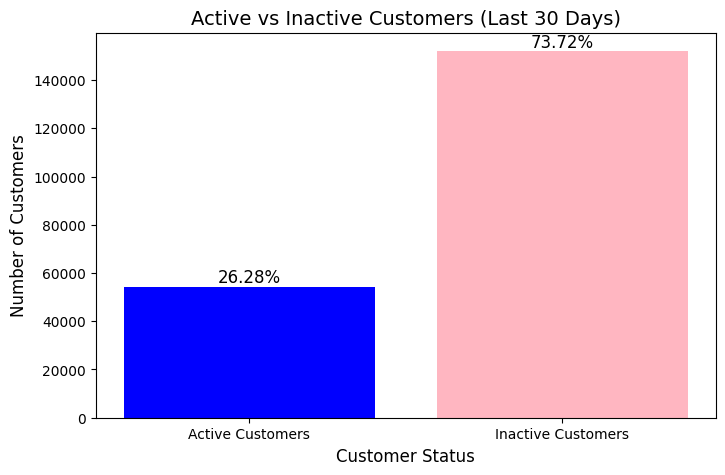

In [30]:
# Data for plotting
categories = ['Active Customers', 'Inactive Customers']
counts = [active_customers_30_days_count, inactive_customers_30_days_count]
percentages = [active_rate_30_days, churn_rate_30_days]

# Create the plot
plt.figure(figsize=(8, 5))
bars = plt.bar(categories, counts, color=['blue', 'lightpink'])
plt.title('Active vs Inactive Customers (Last 30 Days)', fontsize=14)
plt.xlabel('Customer Status', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Add percentage annotations above the bars
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, f'{percentages[i]:.2f}%', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()

# Future churn percentages

### Feature Engineering:
We calculate days_since_last_order, which represents how many days have passed since the customer's last order.
The churned column is created by checking if the days_since_last_order is greater than the churn_threshold (30 days).

### Define feature and target

In [289]:
# Add a small constant to avoid division by zero in 'order_frequency'
customer_activity_df['order_frequency'] = 1 / (customer_activity_df['max_days_since_prior'] + 1e-5)

# Replace infinite values with a large cap
customer_activity_df['order_frequency'].replace([np.inf, -np.inf], np.nan, inplace=True)
customer_activity_df['order_frequency'].fillna(customer_activity_df['order_frequency'].max(), inplace=True)

# Define target variable 'is_churn' based on threshold
customer_activity_df['is_churn'] = customer_activity_df['max_days_since_prior'] >= 30

print(customer_activity_df.head())

# Save results to CSV
customer_activity_df.to_csv("/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/csv/corelation_churn.csv", index=False)
print("Results have been saved to corelation_churn.csv")

/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_46084/52073007.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_activity_df['order_frequency'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_46084/52073007.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object

   user_id  max_days_since_prior  order_frequency  is_churn
0      313                   5.0         0.200000     False
1     4978                   6.0         0.166666     False
2    25635                   6.0         0.166666     False
3    31570                   4.0         0.249999     False
4    31834                   2.0         0.499998     False
Results have been saved to corelation_churn.csv


In [232]:
# Calculate correlation matrix
correlation_matrix = customer_activity_df[['user_id','max_days_since_prior', 'order_frequency', 'is_churn']].corr()

# Reset index and reshape into long format
correlation_long = correlation_matrix.reset_index().melt(id_vars='index')
correlation_long.columns = ['Variable1', 'Variable2', 'Correlation']

# Save to CSV for Tableau
correlation_long.to_csv("/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/csv/corelation_long.csv", index=False)
print("Correlation long format has been saved to corelation_long.csv")


Correlation long format has been saved to corelation_long.csv


Correlation Matrix:
                       user_id  max_days_since_prior  order_frequency  \
user_id               1.000000              0.002498         0.000383   
max_days_since_prior  0.002498              1.000000        -0.024526   
order_frequency       0.000383             -0.024526         1.000000   
is_churn              0.003238              0.825387        -0.009059   

                      is_churn  
user_id               0.003238  
max_days_since_prior  0.825387  
order_frequency      -0.009059  
is_churn              1.000000  


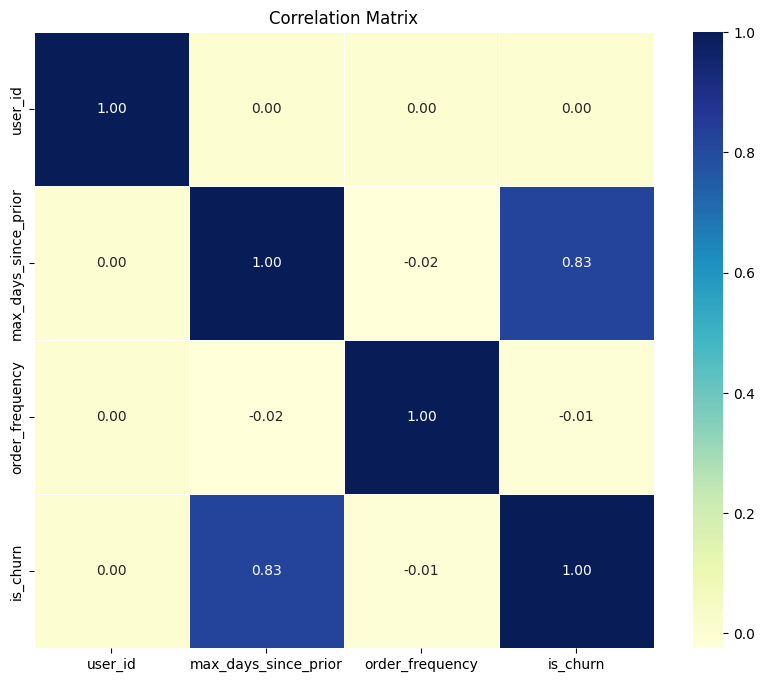

In [291]:
correlation_matrix = customer_activity_df.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix with a different color palette
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


### Modeling:

In [4]:
import pandas as pd
from sqlalchemy import create_engine

# Set up the connection to BigQuery
project_id = 'instacart-441209'
DATABASE_URI = f'bigquery://{project_id}'
engine = create_engine(DATABASE_URI)

# Define the query to join the required tables
query = """
SELECT 
    op.order_id,
    op.product_id,
    op.add_to_cart_order,
    op.reordered,
    p.product_name,
    p.aisle_id,
    p.department_id,
    a.aisle,
    d.department,
    o.user_id,
    o.eval_set,
    o.order_number,
    o.order_dow,
    o.order_hour_of_day,
    o.days_since_prior_order
FROM 
    `instacart-441209.instacart.order_products_train` AS op
JOIN 
    `instacart-441209.instacart.products` AS p
    ON op.product_id = p.product_id
JOIN 
    `instacart-441209.instacart.aisles` AS a
    ON p.aisle_id = a.aisle_id
JOIN 
    `instacart-441209.instacart.departments` AS d
    ON p.department_id = d.department_id
JOIN 
    `instacart-441209.instacart.orders` AS o
    ON op.order_id = o.order_id

-- Join the prior table with the same set of tables
LEFT JOIN 
    `instacart-441209.instacart.order_products_prior` AS op_prior
    ON op_prior.order_id = op.order_id AND op_prior.product_id = op.product_id

"""

# Execute the query and load the result into a pandas DataFrame
order_products = pd.read_sql(query, engine)

# Display the first few rows of the DataFrame
print(order_products.head())

/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_1882/2030312936.py:7: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pybigquery.sqlalchemy_bigquery.BigQueryDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine(DATABASE_URI)


   order_id  product_id  add_to_cart_order  reordered  \
0    946115       10107                  1          0   
1   3232414       11292                  1          0   
2    187392       13370                  2          0   
3   1491360       19966                  3          0   
4    296494       12086                  5          0   

                                        product_name  aisle_id  department_id  \
0                 Light Corn Syrup with Real Vanilla        29             13   
1                    The Original Irish Creme Liquer       124              5   
2                    Packaging Tape High Performance        87             17   
3                          Spicy Shrimp Avocado Roll        13             20   
4  Antibacterial Kitchen All Purpose Spray Cleane...       114             17   

                   aisle department  user_id eval_set  order_number  \
0  honeys syrups nectars     pantry   139639    train             9   
1                spirits    

In [16]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import os
from google.cloud import bigquery

# Set the path to your service account credentials JSON file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"/Users/rishikeshdhokare/Documents/Ironhack/instacart-441209-84de4dcbf601.json"

# Initialize BigQuery Client
client = bigquery.Client(project='instacart-441209')

# Define the SQL query to fetch data
query = """
SELECT
    op.order_id,
    op.product_id,
    op.add_to_cart_order,
    op.reordered,
    p.product_name,
    p.aisle_id,
    p.department_id,
    a.aisle,
    d.department,
    o.user_id,
    o.eval_set,
    o.order_number,
    o.order_dow,
    o.order_hour_of_day,
    o.days_since_prior_order
FROM
    `instacart-441209.instacart.order_products_train` AS op
JOIN
    `instacart-441209.instacart.products` AS p
    ON op.product_id = p.product_id
JOIN
    `instacart-441209.instacart.aisles` AS a
    ON p.aisle_id = a.aisle_id
JOIN
    `instacart-441209.instacart.departments` AS d
    ON p.department_id = d.department_id
JOIN
    `instacart-441209.instacart.orders` AS o
    ON op.order_id = o.order_id
LEFT JOIN
    `instacart-441209.instacart.order_products_prior` AS op_prior
    ON op_prior.order_id = op.order_id AND op_prior.product_id = op.product_id
"""

# Run the query and fetch the results into a pandas DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Step 1: Drop non-numeric columns and handle categorical features (encode them)
categorical_columns = ['product_name', 'eval_set']
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Step 2: One-hot encode 'aisle' and 'department' columns using get_dummies()
df = pd.get_dummies(df, columns=['aisle', 'department', 'eval_set'], drop_first=True)

# Step 3: Define the target variable 'y' and the feature matrix 'X'
y = df['days_since_prior_order']
X = df.drop(columns=['days_since_prior_order', 'product_name'])  # Drop non-numeric and target column

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Initialize and train the XGBoost regressor model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

# Step 6: Predict on the test set
y_pred = model.predict(X_test)

# Step 7: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")


Mean Absolute Error: 8.05865454739447
Mean Squared Error: 86.15768289760463
R2 Score: 0.20849984738914895


In [12]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [100, 200, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=50, scoring='neg_mean_absolute_error', cv=3, verbose=1, random_state=42, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [16]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

estimators = [
    ('xgb', xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=5))
]

stack_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stack_model.fit(X_train, y_train)
y_pred_stack = stack_model.predict(X_test)
print(y_pred_stack)

[23.07515431 18.85707928 11.08517925 ... 22.58145115 18.90690321
  6.94333973]


In [18]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5), X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Cross-Validation MAE:", -scores.mean())

Cross-Validation MAE: 8.234060964938728


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Initialize XGBoost regressor with the best parameters and booster set to 'dart'
best_xgb_model_dart = xgb.XGBRegressor(
    learning_rate=0.05,
    max_depth=10,
    n_estimators=500,
    subsample=1.0,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    booster='dart',  # Using the 'dart' booster
    random_state=42
)

# Train the model
best_xgb_model_dart.fit(X_train, y_train)

# Predict on the test set
y_pred_dart = best_xgb_model_dart.predict(X_test)

# Evaluate the model
mae_dart = mean_absolute_error(y_test, y_pred_dart)
mse_dart = mean_squared_error(y_test, y_pred_dart)
r2_dart = r2_score(y_test, y_pred_dart)

print(f'Mean Absolute Error (MAE): {mae_dart}')
print(f'Mean Squared Error (MSE): {mse_dart}')
print(f'R-squared (R2): {r2_dart}')


KeyboardInterrupt: 

In [8]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import os
import optuna
from google.cloud import bigquery

# Set up BigQuery credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"/Users/rishikeshdhokare/Documents/Ironhack/instacart-441209-84de4dcbf601.json"

# Initialize BigQuery Client
client = bigquery.Client(project='instacart-441209')

# Define SQL query to fetch data
query = """
SELECT
    op.order_id,
    op.product_id,
    op.add_to_cart_order,
    op.reordered,
    p.product_name,
    p.aisle_id,
    p.department_id,
    a.aisle,
    d.department,
    o.user_id,
    o.eval_set,
    o.order_number,
    o.order_dow,
    o.order_hour_of_day,
    o.days_since_prior_order
FROM
    `instacart-441209.instacart.order_products_train` AS op
JOIN
    `instacart-441209.instacart.products` AS p
    ON op.product_id = p.product_id
JOIN
    `instacart-441209.instacart.aisles` AS a
    ON p.aisle_id = a.aisle_id
JOIN
    `instacart-441209.instacart.departments` AS d
    ON p.department_id = d.department_id
JOIN
    `instacart-441209.instacart.orders` AS o
    ON op.order_id = o.order_id
LEFT JOIN
    `instacart-441209.instacart.order_products_prior` AS op_prior
    ON op_prior.order_id = op.order_id AND op_prior.product_id = op.product_id
"""
# Run the query and fetch results into DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Take a small sample of the data for faster tuning
df_sample = df.sample(frac=0.05, random_state=42)  # Sample 5% of data

# Step 1: Find the maximum value of 'days_since_prior_order'
max_days_since_prior_order = df_sample['days_since_prior_order'].max()

# Step 2: Encode categorical features
categorical_columns = ['product_name', 'eval_set']
for col in categorical_columns:
    le = LabelEncoder()
    df_sample[col] = le.fit_transform(df_sample[col])

# Step 3: One-hot encode 'aisle' and 'department'
df_sample = pd.get_dummies(df_sample, columns=['aisle', 'department', 'eval_set'], drop_first=True)

# Step 4: Define features (X) and target (y)
X = df_sample.drop(columns=['days_since_prior_order', 'product_name'])
y = df_sample['days_since_prior_order']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    
    # Create and train the XGBoost model
    model = xgb.XGBRegressor(**params, tree_method='auto')
    model.fit(X_train, y_train)
    
    # Predict on the test set
    preds = model.predict(X_test)
    
    # Calculate and return the mean absolute error
    mae = mean_absolute_error(y_test, preds)
    return mae

# Step 5: Run Bayesian Optimization with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print best hyperparameters
print("Best parameters:", study.best_params)

# Step 6: Train final model on the full dataset using best parameters
best_params = study.best_params
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)

# Step 7: Predict and evaluate on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")


[I 2024-11-13 16:40:34,112] A new study created in memory with name: no-name-5b1f526d-ee53-48a0-bab7-a3bb6a0585f8
/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_25398/381433148.py:84: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_25398/381433148.py:86: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_25398/381433148.py:87: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

Best parameters: {'max_depth': 10, 'learning_rate': 0.08821019392495014, 'n_estimators': 118, 'subsample': 0.9063103701464744, 'colsample_bytree': 0.6375369624921203}
Mean Absolute Error: 8.113719603774642
Mean Squared Error: 88.49580095350522
R2 Score: 0.18988795129466252


In [10]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Use KFold Cross-Validation to evaluate the model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Print mean and standard deviation of the cross-validation scores
print(f'Mean Absolute Error (CV): {-cv_scores.mean()} ± {cv_scores.std()}')


NameError: name 'best_model' is not defined

In [7]:
# Check data types of each column
print(order_products.dtypes)

order_id                    int64
product_id                  int64
add_to_cart_order           int64
reordered                   int64
product_name               object
aisle_id                    int64
department_id               int64
aisle                      object
department                 object
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object


In [22]:
order_products['max_days_since_prior'] = order_products['days_since_prior_order'].max()

features = order_products[['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'aisle_id', 'department_id',
       'user_id', 'order_number', 'order_dow', 'order_hour_of_day']]
target = order_products['max_days_since_prior']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

### KNN Model

In [24]:
normalizer = MinMaxScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Set up K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_norm, y_train)

# Predict on the test set
y_pred = knn.predict(X_test_norm)

# Calculate accuracy
knn_accuracy = accuracy_score(y_test, y_pred)
print("KNN Model Accuracy:", knn_accuracy)

input_features = [[30, 1/30]]
input_features_normalized = normalizer.transform(input_features)

predicted_churn_prob = knn.predict_proba(input_features_normalized)[0][1] * 100
print(f"Predicted churn rate for the next 30 days: {predicted_churn_prob:.2f}%")


KNN Model Accuracy: 1.0


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


ValueError: X has 2 features, but MinMaxScaler is expecting 10 features as input.

In [ ]:
features = customer_activity_df[['max_days_since_prior', 'order_frequency']]  
target = customer_activity_df['is_churn']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

### Decision Tress

In [186]:
tree_clf = DecisionTreeClassifier(max_depth=10)
tree_clf.fit(X_train_norm, y_train)

pred = tree_clf.predict(X_test_norm)
print("MAE:", mean_absolute_error(pred, y_test))
print("RMSE:", mean_squared_error(pred, y_test, squared=False))
print("Accuracy:", tree_clf.score(X_test_norm, y_test))

input_features = [[30, 1/30]]
predicted_churn_prob = tree_clf.predict_proba(input_features)[0][1] * 100
print(f"Predicted churn rate for the next 30 days: {predicted_churn_prob:.2f}%")

MAE: 0.0
RMSE: 0.0
Accuracy: 1.0
Predicted churn rate for the next 30 days: 100.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Logistic Regression

In [255]:
og_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict classes on the test set
y_pred_class = log_reg.predict(X_test)

# Classification metrics
accuracy_log_reg = accuracy_score(y_test, y_pred_class)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_class)
class_report_log_reg = classification_report(y_test, y_pred_class)
roc_auc_log_reg = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])

print("\nLogistic Regression Results:")
print(f'Accuracy: {accuracy_log_reg * 100:.2f}%')
print("Confusion Matrix:")
print(conf_matrix_log_reg)
print("Classification Report:")
print(class_report_log_reg)
print(f'ROC AUC Score: {roc_auc_log_reg:.2f}')

# Predict churn probability for a specific input
input_features = [[30, 1/30]]  # Example values based on features 'max_days_since_prior' and 'order_frequency'
predicted_churn_prob = log_reg.predict_proba(input_features)[0][1] * 100
print(f"Predicted churn rate for the next 30 days: {predicted_churn_prob:.2f}%")


Logistic Regression Results:
Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

ROC AUC Score: 1.00
Predicted churn rate for the next 30 days: 99.99%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Random Forest Classifier

In [257]:
# Initialize and train Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Predict churn on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Predict churn rate for the next 30 days based on Random Forest model
predicted_churn_prob = rf_model.predict_proba([[30, 1/30]])[0][1] * 100
print(f"Predicted churn rate for the next 30 days (Random Forest): {predicted_churn_prob:.2f}%")


Random Forest Model Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

Predicted churn rate for the next 30 days (Random Forest): 100.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Oversampling with SMOTE

In [259]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print("Class distribution after SMOTE:", y_train_resampled.value_counts())

# Initialize and train the Random Forest model on the resampled data
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict churn on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

sample_input = [[30, 1/30]]
predicted_churn_prob = rf_model.predict_proba(sample_input)[0][1] * 100
print(f"Predicted churn rate for the next 30 days: {predicted_churn_prob:.2f}%")


Class distribution after SMOTE: is_churn
True     106328
False    106328
Name: count, dtype: int64
Random Forest Model Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

Predicted churn rate for the next 30 days: 100.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Undersampling

In [261]:
# Initialize RandomUnderSampler and apply it to the training set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print("Class distribution after undersampling:", y_train_resampled.value_counts())

# Initialize and train Random Forest model on resampled data
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict churn on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Predict churn rate for the next 30 days based on Random Forest model
predicted_churn_prob = rf_model.predict_proba([[30, 1/30]])[0][1] * 100
print(f"Predicted churn rate for the next 30 days: {predicted_churn_prob:.2f}%")


Class distribution after undersampling: is_churn
False    38018
True     38018
Name: count, dtype: int64
Random Forest Model Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

Predicted churn rate for the next 30 days: 100.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Add Cluster-Based Features

In [263]:
customer_activity_df['is_churn'] = customer_activity_df['max_days_since_prior'] >= 30

# Select features for clustering and target variable
X_clustering = customer_activity_df[['max_days_since_prior', 'order_frequency']]
y = customer_activity_df['is_churn']

# Determine the number of clusters (e.g., 3 clusters)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_activity_df['cluster'] = kmeans.fit_predict(X_clustering)

# Add the new 'cluster' feature to your main dataset
X = customer_activity_df[['max_days_since_prior', 'order_frequency', 'cluster']]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Predict churn on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Predict churn rate for the next 30 days based on Random Forest model
predicted_churn_prob = rf_model.predict_proba([[30, 1/30, 1]])[0][1] * 100
print(f"Predicted churn rate for the next 30 days (with clustering): {predicted_churn_prob:.2f}%")

Random Forest Model Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

Predicted churn rate for the next 30 days (with clustering): 72.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Gradient Boosting Classifier

In [271]:
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = gb_clf.predict_proba(X_test)[:, 1]  # Use probabilities for the positive class

# For regression metrics, use predicted probabilities instead of class predictions
mse_gb = mean_squared_error(y_test, y_pred_proba)  # Use probabilities for MSE
r2_gb = r2_score(y_test, y_pred_proba)  # Use probabilities for R^2
print("\nGradient Boosting Classifier Results:")
print(f'Mean Squared Error: {mse_gb:.2f}')
print(f'R^2 Score: {r2_gb:.2f}')

# Predicted churn probability for a specific input
input_features = [[30, 1/30, 1]] 
predicted_churn_prob = gb_clf.predict_proba(input_features)[0][1] * 100
print(f"Predicted churn rate for the next 30 days: {predicted_churn_prob:.2f}%")


Gradient Boosting Classifier Results:
Mean Squared Error: 0.00
R^2 Score: 1.00
Predicted churn rate for the next 30 days: 100.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


### Ada Boost Regressor

In [275]:
# Base model
base_model = DecisionTreeRegressor(max_depth=3)  

# AdaBoost model
ada_model = AdaBoostRegressor(estimator=base_model, n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_ada = ada_model.predict(X_test)

# Calculate regression metrics
mse_ada = mean_squared_error(y_test, y_pred_ada)
r2_ada = r2_score(y_test, y_pred_ada)
print("\nAdaptive Boosting Results:")
print(f'Mean Squared Error: {mse_ada:.2f}')
print(f'R^2 Score: {r2_ada:.2f}')

# Predicted churn probability (just predicted value, not a probability)
predicted_churn_value = ada_model.predict([[30, 1/30, 1]])[0]  # Single prediction
print(f"Predicted churn value for the next 30 days: {predicted_churn_value:.2f}")


Adaptive Boosting Results:
Mean Squared Error: 0.00
R^2 Score: 1.00
Predicted churn value for the next 30 days: 1.00


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


In [277]:
# Make predictions for the next 30 days
predicted_churn_df = customer_activity_df.copy()
predicted_churn_df['churn_prediction'] = model.predict(features)

# Calculate predicted churn rate
predicted_churn_customers = predicted_churn_df[predicted_churn_df['churn_prediction'] == 1]
predicted_churn_rate = (predicted_churn_customers['user_id'].nunique() / total_customers) * 100

# Print the predicted churn rate for the next 30 days
print("\nPredicted Churn rate for next 30 days:", predicted_churn_rate)


Predicted Churn rate for next 30 days: 73.71744201271525
